## Tutorial on collision avoidance with optimization fabrics

---

This tutorial will walk you through a first trajectory generator with optimization fabrics.\
Let's start by importing the necessary components for fabrics.

In [1]:
import casadi as ca
import numpy as np
from fabrics.diffGeometry.diffMap import DifferentialMap
from fabrics.diffGeometry.energy import Lagrangian
from fabrics.diffGeometry.geometry import Geometry
from fabrics.helpers.variables import Variables
from fabrics.diffGeometry.energized_geometry import WeightedGeometry

### Simulation

For visualization, we also want to run a simulation of our first planner, using: https://github.com/maxspahn/gym_envs_planar.

In [4]:
import gym
import planarenvs.point_robot
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

def run_environment(
        weighted_geometry,
        render=False,
        dt = 0.001,
        T= 20,
        obstacles = [],
        init_vel = [1.0, 0.1],
        init_pos = [0.5, 0.1],
    ):
    
    # Using openai gym interface for the simulation
    env = gym.make("point-robot-acc-v0", render=render, dt=dt)
    n_steps = int(T/dt)
    
    positions = []
    ob = env.reset(pos=np.array(init_pos), vel=np.array(init_vel))
    for obstacle in obstacles:
        env.add_obstacle(obstacle)
    for i in range(n_steps):
        x = ob['joint_state']['position']
        xdot = ob['joint_state']['velocity']
        positions.append(x)
        
        # Simple logging to monitor the proces
        if i % (1/dt) == 0:
            print(f"Current time : {i * dt}/{T}")            
        
        # Use a weighted geometry to compute the action
        _, _, xddot, alpha = weighted_geometry.evaluate(q=x,qdot=xdot)
        action = xddot - alpha * xdot

        # Break if something goes horribly wrong
        if np.linalg.norm(action) > 1e5:
            print(f"Breaking due to action magnitude at step {dt*i}, {x}")
            break
        if np.any(np.isnan(action)):
            print(f"Breaking due to isnan at step {dt*i}, {x}")
            break
        if np.linalg.norm(xdot) > 1.2 * np.linalg.norm(np.array(init_vel)):
            print(f"Breaking due to velocity magnitude at step {dt*i}, {x}")
            break

        ob, _, _, _ = env.step(action)
    env.close()
    return np.array(positions)

### Visualizations

We use matplotlib for visualizations of the trajectories.

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_trajectory(positions, qmax=None, obstacles = []):
    fig, axs = plt.subplots(1, 1)
    axs.plot(positions[:,0], positions[:,1])
    axs.axis('on')

    for obstacle in obstacles:
        axs.add_patch(plt.Circle(obstacle.position(), radius=obstacle.radius(), color='r'))
    axs.axis('equal')
    
    if qmax:
        ell = Ellipse(xy=[0,0], width=qmax[0]*2.02, height=qmax[1]*2.02, angle=0,
              edgecolor='r', lw=1, facecolor='none')
        axs.add_artist(ell)
        axs.set_xlim([-1.3 * qmax[0], 1.3 * qmax[0]])
        axs.set_ylim([-1.3 * qmax[1], 1.3 * qmax[1]])
    return plt

### Base geometry
Now, we can start building the planner.\
We define our configuration space variables $\bf{q} \in \mathcal{Q} = \mathcal{R}^2$ and $\dot{\bf{q}} \in \mathcal{R}^2$.

Then, we define a base geometry using the `Geometry`-class with a zero forcing term $\bf{h}_b = \bf{0}$.\
We equip it with a `Lagrangian` with the energy $\mathcal{L}e_b = \frac{1}{2}\dot{\bf{q}}^T\dot{\bf{q}}$.

We energize the base fabric $(\bf{M}_b, \bf{f}_b)_{\mathcal{Q}}$ by creating an instance of `WeightedGeometry` by providing the Lagrangian and the geometry.

Then, we verify if $\bf{M}_b = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix}$ and $\bf{f}_b = \begin{pmatrix}0 \\ 0 \end{pmatrix}$.

> Note that all calculations are done symbolically.

In [7]:
q = ca.SX.sym('q', 2)
qdot = ca.SX.sym('qdot', 2)
config_variables = Variables(state_variables={'q': q, 'qdot': qdot})
geo_b = Geometry(var=config_variables, h=ca.SX(np.zeros(2)))
lag_b = Lagrangian(0.5 * ca.norm_2(qdot)**2, var=config_variables)
fabric_b = WeightedGeometry(le=lag_b, g=geo_b)
print(f"M={fabric_b.M()}")
print(f"f={fabric_b.f()}")

M=@1=1, 
[[@1, 00], 
 [00, @1]]
f=@1=0, [@1, @1]


#### Visualization base geometry
We can simulate and visualize that.\
First, we need to turn the symbolic expression into concrete functions using the `concretize` method.

> This method is available for most components inside the package and is usually followed by an `evaluate` call.\
See run_environment for that call.

What sort of trajectory do you expect when we run it now?

In [10]:
fabric_b.concretize()
positions_b = run_environment(fabric_b)

Current time : 0.0/20
Current time : 1.0/20
Current time : 2.0/20
Current time : 3.0/20
Current time : 4.0/20
Current time : 5.0/20
Current time : 6.0/20
Current time : 7.0/20
Current time : 8.0/20
Current time : 9.0/20
Current time : 10.0/20
Current time : 11.0/20
Current time : 12.0/20
Current time : 13.0/20
Current time : 14.0/20
Current time : 15.0/20
Current time : 16.0/20
Current time : 17.0/20
Current time : 18.0/20
Current time : 19.0/20


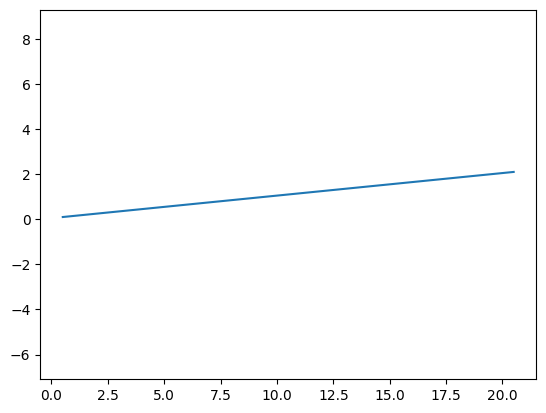

In [11]:
plot_trajectory(positions_b).show()

### Limit geometry
So, that wasn't too exciting.\
Let us define workspace limits using a simple ellipsoid of form 

$\left(\frac{q_0}{q_{0,max}}\right)^2 + \left(\frac{q_1}{q_{1,max}}\right)^2= 1$.

We start by defining the manifold variables $\bf{x} \in \mathcal{X} = \mathcal{R}^1$ and $\bf{\dot{x}} \in \mathcal{R}^1$.\
Then, we set the maximum axis values `q_max`.\
With that, we can define the `DifferentialMap` as $\phi_{l} = 1 - \left(\frac{q_0}{q_{0,max}}\right)^2 + \left(\frac{q_1}{q_{1,max}}\right)^2$

We define the limit geometry as:\
$\bf{h}$$_l= \frac{-sgn(\bf{\dot{x}})}{2\bf{x}^2} $.

We equip it with a metric using a `Lagrangian`:\
$\mathcal{L}_l = \frac{\bf{\dot{x}}^2}{5\bf{x}^2} $


In [12]:
#Defiine the manifold variables
x = ca.SX.sym(f"x_limit", 1)
xdot = ca.SX.sym(f"xdot_limit", 1)
variables_l = Variables(state_variables={'x': x, 'xdot': xdot})

q_max = [1.3, 1.1]
phi_l  = 1 - ((q[0]/q_max[0])**2 + (q[1]/q_max[1])**2)
diff_l = DifferentialMap(phi_l, config_variables)

h_l = -0.5/(x**2) * xdot**2  * (-0.5 * (ca.sign(xdot) - 1))
geo_l = Geometry(var=variables_l, h=h_l)
l_l = 0.2/(x**2) * ca.norm_2(xdot)**2
lag_l = Lagrangian(l_l, var=variables_l)

fabric_l = fabric_b + WeightedGeometry(le=lag_l, g=geo_l).pull(diff_l)

#### Visualization limit geometry
This fabric is numerically unstable, see for `T=20` in the following cell.\
We thus first energize this fabric_l with a simple execution energy.

> Note that this energization is typical for optimization fabrics and will be used for most planners.

In [13]:
fabric_l.concretize()
positions_l = run_environment(fabric_l, T=10)

l_exec = Lagrangian(0.5 * ca.norm_2(qdot)**2, var=config_variables)
final_geo = WeightedGeometry(g=Geometry(s=fabric_l), le=l_exec)
final_geo.concretize()
positions_l_ex = run_environment(final_geo, T=10)

Current time : 0.0/10
Current time : 1.0/10
Current time : 2.0/10
Current time : 3.0/10
Current time : 4.0/10


Current time : 5.0/10
Breaking due to velocity magnitude at step 5.339, [-0.33695647 -1.06220805]
Current time : 0.0/10
Current time : 1.0/10
Current time : 2.0/10
Current time : 3.0/10
Current time : 4.0/10
Current time : 5.0/10
Current time : 6.0/10
Current time : 7.0/10
Current time : 8.0/10
Current time : 9.0/10


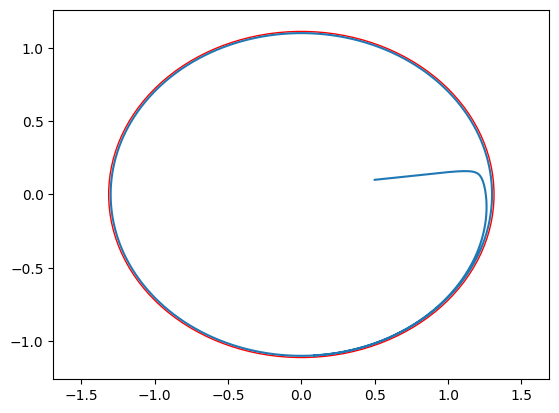

In [14]:
#plot_trajectory(positions_l, qmax=q_max).show()
plot_trajectory(positions_l_ex, qmax=q_max).show()

### Obstacle geometry

Next, we add obstacles to the environment and thus also to the fabric.\
Let us first define some obstacles within the ellipsoid.\
The entries are `[x_obst, y_obst, radius_obst]`.

In [15]:
from mpscenes.obstacles.sphere_obstacle import SphereObstacle
obstacle_geometries = [
    [0.7, 0.3, 0.2],
    [-0.4, 0.5, 0.1],
    [0.0, -0.5, 0.2],
    [-0.5, 0, 0.2],
]

Based on this information, we create a list of `SphereObstacle` from https://github.com/maxspahn/motion_planning_scenes. \
They can be added to the environment for visualization.

In [16]:
obstacles = []
for obstacle_geometry in obstacle_geometries:
    circle_dict = {
        'type': 'SphereObstacle',
        'geometry': {
            'position': obstacle_geometry[0:2],
            'radius': obstacle_geometry[2],
        }
    }
    obstacles.append(SphereObstacle(name="CircleObstacle", content_dict = circle_dict))

Similar to the limit geometry, we define a `DifferentialMap`, a `Geometry` and a `Lagrangian` for all obstacles. 

In [31]:
fabric_o = None
for i, obstacle in enumerate(obstacles):
    #x = ca.SX.sym(f"x_obst_i", 1)
    #xdot = ca.SX.sym(f"xdot_obst_i", 1)
    x = ca.SX.sym(f"x_obst_{i}", 1)
    xdot = ca.SX.sym(f"xdot_obst_{i}", 1)
    variables = Variables(state_variables={'x': x, 'xdot': xdot})

    h_obst = -2/(x**2) * xdot**2 * (-0.5 * (ca.sign(xdot) - 1))
    le = 2/(x**2) * xdot**2

    geometry_obstacle = Geometry(var=variables, h=h_obst)
    le_obst = Lagrangian(le, var=variables)
    weighted_geometry = WeightedGeometry(le=le_obst, g=geometry_obstacle)
    phi = ca.norm_2(q - obstacle.position()) / obstacle.radius() - 1
    diff_map = DifferentialMap(phi, config_variables)
    if fabric_o:
        print('adding')
        fabric_o += weighted_geometry.pull(diff_map)
    else:
        print('creating')
        fabric_o = weighted_geometry.pull(diff_map)

creating
adding
adding
adding


In [32]:
fabric_o_b = fabric_o + fabric_b

l_exec = Lagrangian(0.5 * ca.norm_2(qdot)**2, var=config_variables)
final_geo = WeightedGeometry(g=Geometry(s=fabric_o_b), le=l_exec)
final_geo.concretize()
positions_o_b = run_environment(final_geo, T=2)

Current time : 0.0/2
Current time : 1.0/2


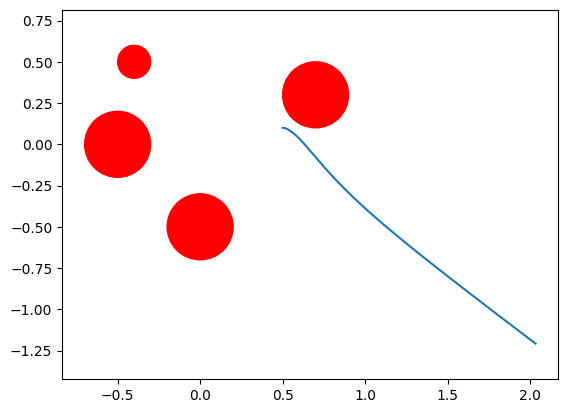

In [33]:
plot_trajectory(positions_o_b, obstacles=obstacles).show()

Now, let us also add the limit geometry using the simple `+` operator.

In [34]:
fabric_o_b_l = fabric_o_b + fabric_l
l_exec = Lagrangian(0.5 * ca.norm_2(qdot)**2, var=config_variables)
final_geo = WeightedGeometry(g=Geometry(s=fabric_o_b_l), le=l_exec)
final_geo.concretize()
positions_o_b_l = run_environment(final_geo)

Current time : 0.0/20
Current time : 1.0/20
Current time : 2.0/20
Current time : 3.0/20
Current time : 4.0/20
Current time : 5.0/20
Current time : 6.0/20
Current time : 7.0/20
Current time : 8.0/20
Current time : 9.0/20
Current time : 10.0/20
Current time : 11.0/20
Current time : 12.0/20
Current time : 13.0/20
Current time : 14.0/20
Current time : 15.0/20
Current time : 16.0/20
Current time : 17.0/20
Current time : 18.0/20
Current time : 19.0/20


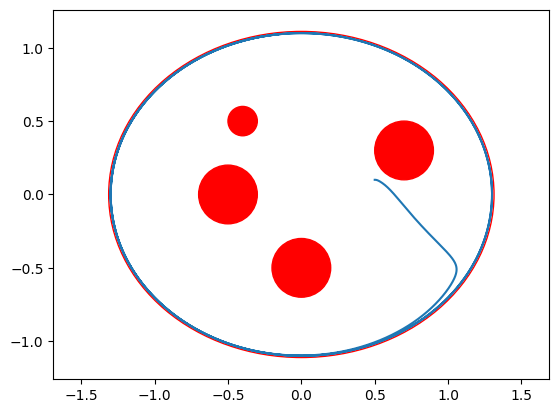

In [35]:
plot_trajectory(positions_o_b_l, qmax=q_max,obstacles=obstacles).show()

Ok, that's nice, but we get stuck on the limit elipsoid.\
Usually, we would like to reach a goal so we will add a goal forcing policy.

### Forcing the fabric

So the great power of fabrics is that we can arbitrarily add different geometries (as we did with the limits and the obstacles) and only in the latest step add the forcing potential.

Let's try that out.\
We first define a goal, again from `mpscenes` at https://github.com/maxspahn/motion_planning_scenes.

In [36]:
from mpscenes.goals.static_sub_goal import StaticSubGoal
goal_dict = {
        "weight": 1.0,
        "is_primary_goal": True,
        "indices": [0, 1],
        "parent_link" : 'origin',
        "child_link" : 'ee_link',
        "desired_position": [-0.5, -0.25],
        "epsilon" : 0.1,
        "type": "staticSubGoal"
    }
goal = StaticSubGoal(name="goal", content_dict=goal_dict)

psi = ca.norm_2(q-goal.position())**2
h_forcing = 1.5 * ca.gradient(psi, q)
forcing_geometry = Geometry(var=config_variables, h=h_forcing)


Now, we add the forcing potential to the final geometry that we have defined earlier.\
Therefore, we change the form of the geometry in the canonical acceleration form $(\bf{I},\bf{h})_{\mathcal{Q}}$.

Only then can we add the forcing geometry.

> We let the following simulation run a bit longer because it looks nice and with a smaller time step to avoid numerical issues.

In [37]:
fabric_tot = fabric_o + fabric_l + fabric_b
composed_geometry = Geometry(s=fabric_tot) + forcing_geometry
l_exec = Lagrangian(0.5 * ca.norm_2(qdot)**2, var=config_variables)
final_geo = WeightedGeometry(g=composed_geometry, le=l_exec)
final_geo.concretize()
positions = run_environment(final_geo, T=50, dt=0.0005)

Current time : 0.0/50
Current time : 1.0/50
Current time : 2.0/50
Current time : 3.0/50
Current time : 4.0/50
Current time : 5.0/50
Current time : 6.0/50
Current time : 7.0/50
Current time : 8.0/50
Current time : 9.0/50
Current time : 10.0/50
Current time : 11.0/50
Current time : 12.0/50
Current time : 13.0/50
Current time : 14.0/50
Current time : 15.0/50
Current time : 16.0/50
Current time : 17.0/50
Current time : 18.0/50
Current time : 19.0/50
Current time : 20.0/50
Current time : 21.0/50
Current time : 22.0/50
Current time : 23.0/50
Current time : 24.0/50
Current time : 25.0/50
Current time : 26.0/50
Current time : 27.0/50
Current time : 28.0/50
Current time : 29.0/50
Current time : 30.0/50
Current time : 31.0/50
Current time : 32.0/50
Current time : 33.0/50
Current time : 34.0/50
Current time : 35.0/50
Current time : 36.0/50
Current time : 37.0/50
Current time : 38.0/50
Current time : 39.0/50
Current time : 40.0/50
Current time : 41.0/50
Current time : 42.0/50
Current time : 43.0/5

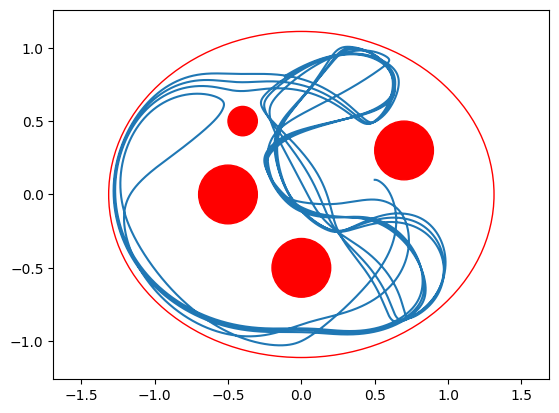

In [38]:
plot_trajectory(positions, q_max, obstacles=obstacles).show()

---

## SUCCESS

Nice, you made it!

I hope it helped you a bit to understand how to use optimization fabrics and the package `fabrics`.\
The next step is to understand the `ParameterizedFabricPlanner`.